<a href="https://colab.research.google.com/github/ruslanraupoff/machine-vision-057601/blob/master/anomalylstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [ ]:
!pip install keras-layer-normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
EPOCHS = 3
BATCH_SIZE = 4
BASE_DIR = '/content/drive/MyDrive/Sejong/Machine Vision/'
DATASET_PATH = BASE_DIR + 'data/UCSDped1/Train'
MODEL_PATH = BASE_DIR + 'models/model_lstm.hdf5'

In [ ]:
import shelve
import numpy as np
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join, isdir

import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization

2022-06-15 08:04:03.782526: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
def get_clips_by_stride(stride, frames_list, sequence_size):
  """ For data augmenting purposes.
  Parameters
  ----------
  stride : int
      The desired distance between two consecutive frames
  frames_list : list
      A list of sorted frames of shape 256 X 256
  sequence_size: int
      The size of the desired LSTM sequence
  Returns
  -------
  list
      A list of clips , 10 frames each
  """
  clips = []
  sz = len(frames_list)
  clip = np.zeros(shape=(sequence_size, 256, 256, 1))
  cnt = 0
  for start in range(0, stride):
    for i in range(start, sz, stride):
      clip[cnt, :, :, 0] = frames_list[i]
      cnt = cnt + 1
      if cnt == sequence_size:
        clips.append(np.copy(clip))
        cnt = 0
  return clips


def get_training_set():
  """
  Returns
  -------
  list
      A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
  """
  #####################################
  # cache = shelve.open(CACHE_PATH)
  # return cache["datasetLSTM"]
  #####################################
  clips = []
  # loop over the training folders (Train000,Train001,..)
  for f in sorted(listdir(DATASET_PATH)):
    if isdir(join(DATASET_PATH, f)):
      all_frames = []
      # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
      for c in sorted(listdir(join(DATASET_PATH, f))):
        if str(join(join(DATASET_PATH, f), c))[-3:] == "tif":
          img = Image.open(join(join(DATASET_PATH, f), c)).resize((256, 256))
          img = np.array(img, dtype=np.float32) / 256.0
          all_frames.append(img)
      # get the 10-frames sequences from the list of images after applying data augmentation
      for stride in range(1, 3):
        clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [ ]:
def get_model(reload_model=True):
  """
  Parameters
  ----------
  reload_model : bool
      Load saved model or retrain it
  """
  if not reload_model:
    return load_model(MODEL_PATH, custom_objects={'LayerNormalization': LayerNormalization})
  training_set = get_training_set()
  training_set = np.array(training_set)
  training_set = training_set.reshape(-1,10,256,256,1)
  seq = Sequential()
  seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
  seq.add(LayerNormalization())
  seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
  seq.add(LayerNormalization())
  # # # # #
  seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
  seq.add(LayerNormalization())
  seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
  seq.add(LayerNormalization())
  seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
  seq.add(LayerNormalization())
  # # # # #
  seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
  seq.add(LayerNormalization())
  seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
  seq.add(LayerNormalization())
  seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
  print(seq.summary())
  seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
  seq.fit(training_set, training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=False)
  seq.save(MODEL_PATH)
  return seq

In [ ]:
def get_single_test(TEST_PATH):
  sz = 200
  test = np.zeros(shape=(sz, 256, 256, 1))
  cnt = 0
  for f in sorted(listdir(TEST_PATH)):
    if str(join(TEST_PATH, f))[-3:] == "tif":
      img = Image.open(join(TEST_PATH, f)).resize((256, 256))
      img = np.array(img, dtype=np.float32) / 256.0
      test[cnt, :, :, 0] = img
      cnt = cnt + 1
  return test

In [ ]:
#get_model()

In [ ]:
def evaluate(TEST_PATH):
  model = get_model(False)
  print("got model")
  test = get_single_test(TEST_PATH)
  print(test.shape)
  sz = test.shape[0] - 10 + 1
  sequences = np.zeros((sz, 10, 256, 256, 1))
  # apply the sliding window technique to get the sequences
  for i in range(0, sz):
    clip = np.zeros((10, 256, 256, 1))
    for j in range(0, 10):
      clip[j] = test[i + j, :, :, :]
    sequences[i] = clip

  print("got data")
  # get the reconstruction cost of all the sequences
  reconstructed_sequences = model.predict(sequences,batch_size=4)
  sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
  sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
  sr = 1.0 - sa

  # plot the regularity scores
  plt.plot(sr)
  plt.ylabel('regularity score Sr(t)')
  plt.xlabel('frame t')
  plt.show()

2022-06-15 08:04:16.509728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-15 08:04:16.509803: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-15 08:04:16.510653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 225s 5s/step


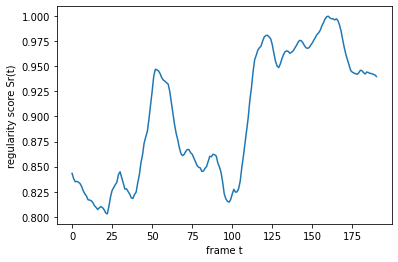

In [ ]:
evaluate(BASE_DIR + 'data/UCSDped1/Test/Test032')

got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 218s 5s/step


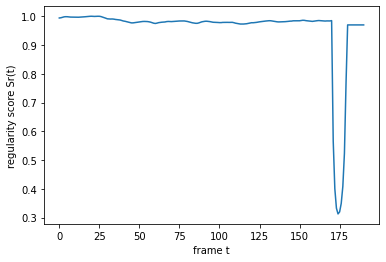

In [ ]:
evaluate(BASE_DIR + 'data/UCSDped2/Test/Test008')

got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 223s 5s/step


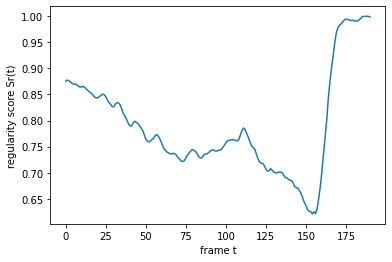

In [ ]:
evaluate(BASE_DIR + 'data/UCSDped1/Test/Test024')

got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 222s 5s/step


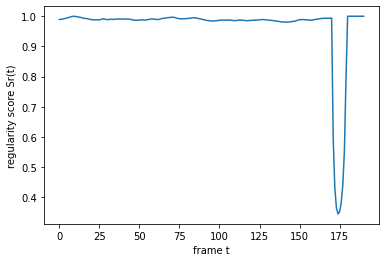

In [ ]:
evaluate(BASE_DIR + 'data/UCSDped2/Test/Test012')